# **Step 1: Data Loading**

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import time
import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [218]:
df = pd.read_csv("Mall_Customers.csv")
print("dataset shape:", df.shape)
df.head()

dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Check for missing values

In [219]:
print("missing values in each column:")
print(df.isnull().sum())
#no messing values

missing values in each column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


# **Step 2: Preprocessing**

In [220]:
df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'SpendingScore'}, inplace=True)

df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

features = ['Gender', 'Age', 'Income', 'SpendingScore']

X = df[features]
#just name replacment to make the work easy

Scaling

In [221]:
#we should use StandardScaler to data beacause the pCA is sensitive to scale
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [222]:
print(df.corr()['Gender'].sort_values(ascending=False))

Gender           1.000000
SpendingScore    0.058109
Income          -0.056410
CustomerID      -0.057400
Age             -0.060867
Name: Gender, dtype: float64


# **Step 3: Dimensionality Reduction - PCA**

explained variance ratios: [0.33690046 0.26230645 0.23260639 0.16818671]
cumulative explained variance: [0.33690046 0.5992069  0.83181329 1.        ]


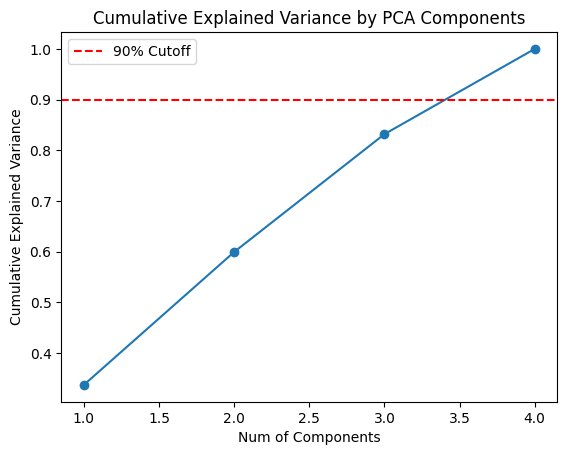

In [223]:
#we apply the pca on the scaled data and Visualize it to see what n_components we should use
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


explained_variance_mall = pca.explained_variance_ratio_.cumsum()

print('explained variance ratios:', pca.explained_variance_ratio_)

print('cumulative explained variance:', explained_variance_mall)



plt.plot(range(1, len(explained_variance_mall)+1),
         explained_variance_mall, marker='o')

plt.axhline(y=0.90,
            color='r',
            linestyle='--',
            label='90% Cutoff')

plt.title("Cumulative Explained Variance by PCA Components")

plt.xlabel("Num of Components")

plt.ylabel("Cumulative Explained Variance")

plt.legend()

plt.show()


choosing the n_components

In [224]:
pca = PCA()

pca.fit(X_scaled)

explained_ratios = pca.explained_variance_ratio_



total_variances = 0

n_components_mall = 0

for ratio in explained_ratios:

    total_variances += ratio

    n_components_mall += 1

    if total_variances >= 0.90:

        break

print("number of components :", n_components_mall)


number of components : 4


applies PCA with selected components and visualizes the data using the first two principal components

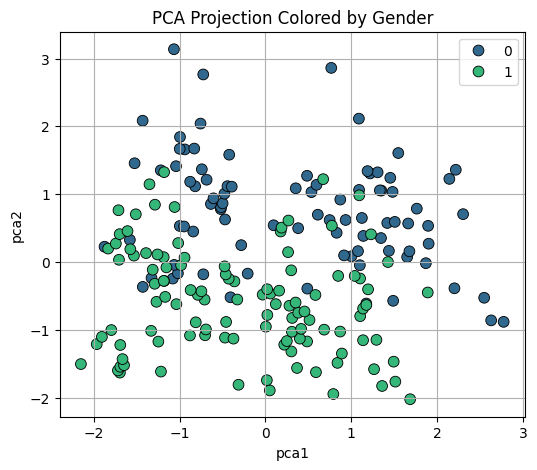

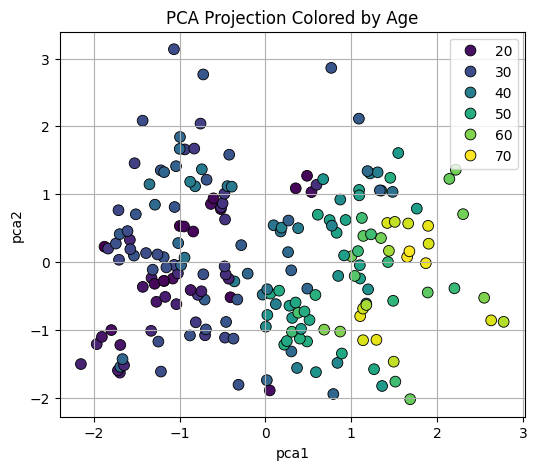

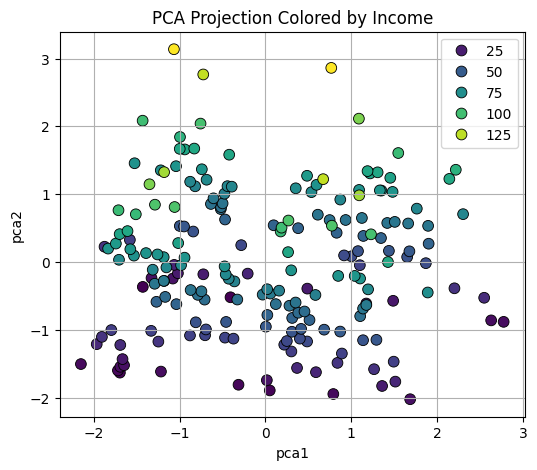

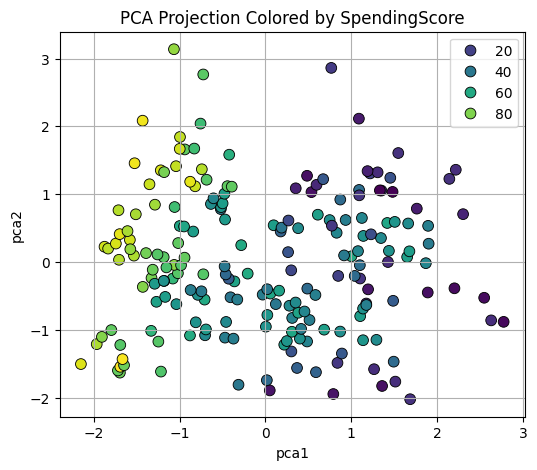

In [225]:
pca_mall_final = PCA(n_components=n_components_mall)

X_mall_pca = pca_mall_final.fit_transform(X_scaled)


pca_df = pd.DataFrame(X_pca[:, :2], columns=["pca1", "pca2"])

pca_df = pd.concat([pca_df, df[features].reset_index(drop=True)], axis=1)


for col in features:
    plt.figure(figsize=(6, 5))

    sns.scatterplot(
        data=pca_df,
        x="pca1", y="pca2",
        hue=col,
        palette="viridis",
        s=60,
        edgecolor='black'
    )

    plt.title(f"PCA Projection Colored by {col}")

    plt.legend(loc="best")

    plt.grid(True)

    plt.show()


# **Step 4: t-SNE Visualization**

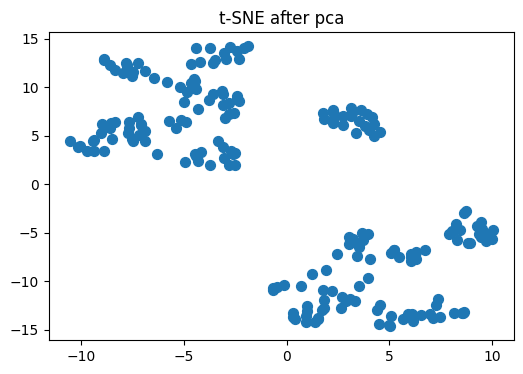

In [226]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_mall_pca)

#t-SNE visualization

plt.figure(figsize=(6,4))

plt.scatter(X_tsne[:,0],
            X_tsne[:,1],
            s=50)

plt.title("t-SNE after pca")

plt.show()

# **Step 5: Clustering**

In [227]:
# K-Means with standard initialization
km_standard = KMeans(n_clusters=4, random_state=42, init='random')
km_standard.fit(X_mall_pca)

KMeans(init='random', n_clusters=4, random_state=42)

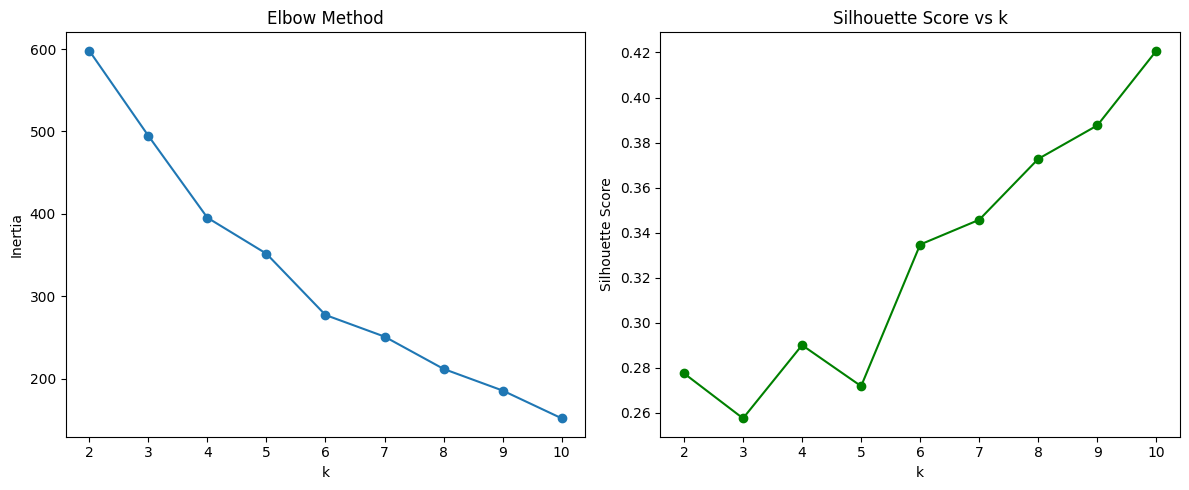

In [228]:
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_mall_pca)
    inertia.append(km.inertia_)
    if k >= 2:
        sil_scores.append(silhouette_score(X_mall_pca, km.labels_))
    else:
        sil_scores.append(0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='green')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()



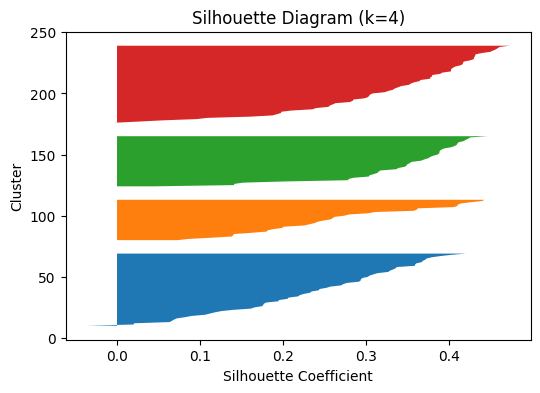

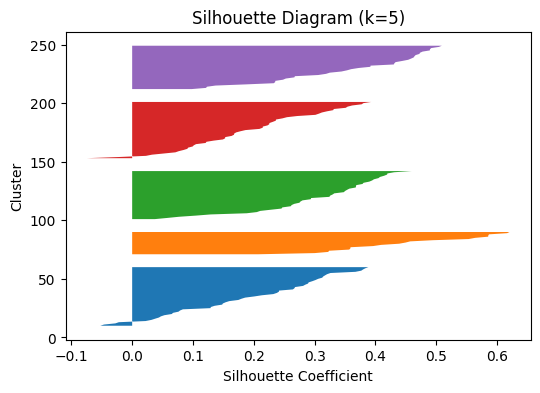

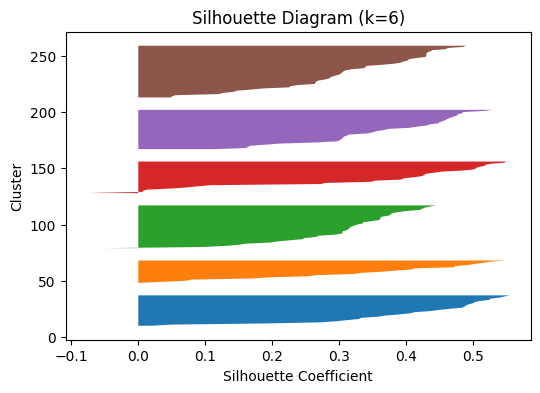

In [229]:
# Silhouette diagrams for multiple k values
for k_val in [4, 5, 6]:
    km = KMeans(n_clusters=k_val, random_state=42)
    labels = km.fit_predict(X_mall_pca)
    sil_samples = silhouette_samples(X_mall_pca, labels)

    plt.figure(figsize=(6,4))
    y_lower = 10
    for i in range(k_val):
        ith_cluster_sil_values = sil_samples[labels == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values)
        y_lower = y_upper + 10

    plt.title(f"Silhouette Diagram (k={k_val})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

In [230]:
# K-Means with K-Means++ initialization
km_plusplus = KMeans(n_clusters=4, random_state=42, init='k-means++')
km_plusplus.fit(X_mall_pca)

KMeans(n_clusters=4, random_state=42)

In [231]:
print("Inertia with standard initialization:", km_standard.inertia_)
print("Inertia with K-Means++ initialization:", km_plusplus.inertia_)

Inertia with standard initialization: 389.92403295819327
Inertia with K-Means++ initialization: 395.3920903479796


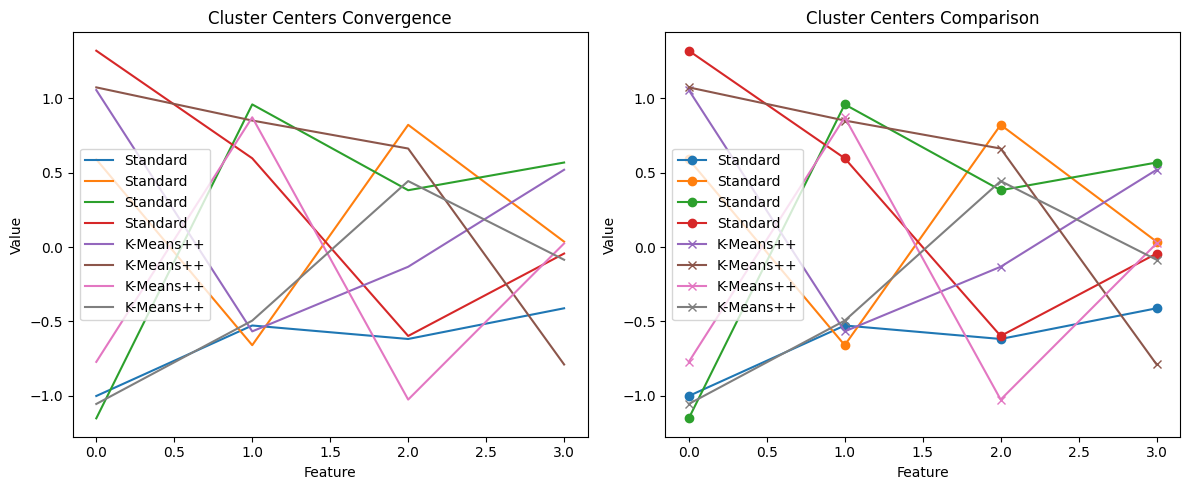

In [232]:
# Plot convergence
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(km_standard.cluster_centers_.T, label='Standard')
plt.plot(km_plusplus.cluster_centers_.T, label='K-Means++')
plt.title("Cluster Centers Convergence")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(km_standard.cluster_centers_.T, label='Standard', marker='o')
plt.plot(km_plusplus.cluster_centers_.T, label='K-Means++', marker='x')
plt.title("Cluster Centers Comparison")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

#**Step 6: MiniBatch KMeans**

In [233]:
start = time.time()
mbkm = MiniBatchKMeans(n_clusters=5, random_state=42)
mbkm.fit(X_mall_pca)
end = time.time()
print("MiniBatchKMeans time:", round(end - start, 4), "seconds")
print("Inertia:", mbkm.inertia_)
print("Silhouette Score:", silhouette_score(X_mall_pca, mbkm.labels_))

MiniBatchKMeans time: 0.0141 seconds
Inertia: 326.8873544598852
Silhouette Score: 0.3168476768813833


# **Step 7: DBSCAN Clustering**

using grid search to find best values

In [234]:
eps_values = np.arange(0.3, 1.1, 0.1)

min_samples_values = range(3, 11)

print("DBSCAN grid search result:")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_mall_pca)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Skip if no clusters found
        if n_clusters <= 1:
            continue

        # Silhouette score requires > 1 cluster
        sil = silhouette_score(X_mall_pca, labels)
        print(f"eps={eps:.1f}, min_samples={min_samples} → clusters={n_clusters}, noise={n_noise}, silhouette={sil:.3f}")


DBSCAN grid search result:
eps=0.3, min_samples=3 → clusters=14, noise=144, silhouette=-0.226
eps=0.3, min_samples=4 → clusters=4, noise=177, silhouette=-0.289
eps=0.4, min_samples=3 → clusters=18, noise=97, silhouette=-0.005
eps=0.4, min_samples=4 → clusters=8, noise=133, silhouette=-0.122
eps=0.4, min_samples=5 → clusters=4, noise=165, silhouette=-0.205
eps=0.4, min_samples=6 → clusters=2, noise=177, silhouette=-0.141
eps=0.4, min_samples=7 → clusters=2, noise=182, silhouette=-0.182
eps=0.5, min_samples=3 → clusters=18, noise=49, silhouette=0.215
eps=0.5, min_samples=4 → clusters=12, noise=76, silhouette=0.121
eps=0.5, min_samples=5 → clusters=9, noise=105, silhouette=0.012
eps=0.5, min_samples=6 → clusters=5, noise=135, silhouette=-0.095
eps=0.5, min_samples=7 → clusters=4, noise=152, silhouette=-0.070
eps=0.5, min_samples=8 → clusters=2, noise=169, silhouette=-0.075
eps=0.5, min_samples=9 → clusters=3, noise=169, silhouette=-0.123
eps=0.5, min_samples=10 → clusters=2, noise=178, si

we choose the best values based on silhouette score

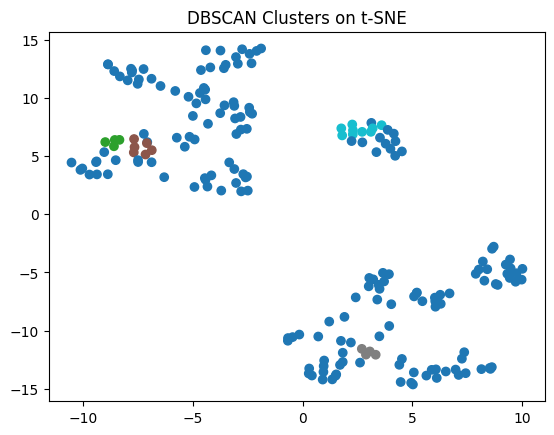

DBSCAN Clusters: 4


In [235]:
dbscan = DBSCAN(eps=0.3, min_samples=4)
db_labels = dbscan.fit_predict(X_mall_pca)
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)

plt.scatter(X_tsne[:,0],
            X_tsne[:,1],
            c=db_labels,
            cmap='tab10')

plt.title("DBSCAN Clusters on t-SNE")

plt.show()

print("DBSCAN Clusters:", n_clusters_db)

# **Step 8: Clustering Comparison with and without PCA**

Silhouette Score without PCA: 0.27191023466188324
Silhouette Score with PCA: 0.27191023466188324


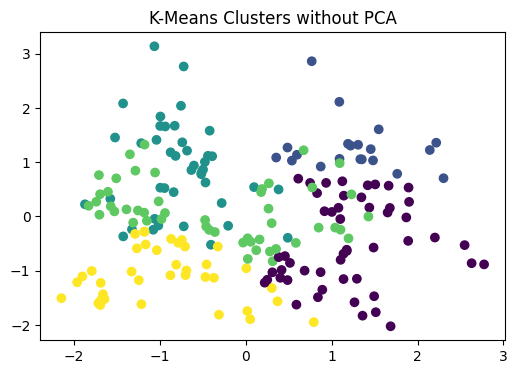

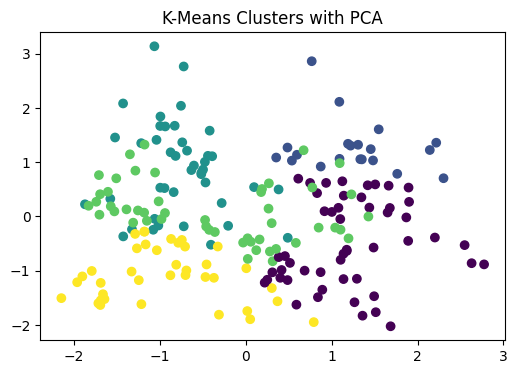

In [236]:
"""# **Step 9: Clustering Comparison with and without PCA**"""

# Clustering without PCA
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# K-Means without PCA
km_no_pca = KMeans(n_clusters=5, random_state=42)
km_no_pca.fit(X_scaled_df)

# Silhouette score without PCA
sil_no_pca = silhouette_score(X_scaled_df, km_no_pca.labels_)

# K-Means with PCA
km_pca = KMeans(n_clusters=5, random_state=42)
km_pca.fit(X_mall_pca)

# Silhouette score with PCA
sil_pca = silhouette_score(X_mall_pca, km_pca.labels_)

print(f"Silhouette Score without PCA: {sil_no_pca}")
print(f"Silhouette Score with PCA: {sil_pca}")

# Visualization without PCA
pca_full = PCA(n_components=2)
X_full_pca = pca_full.fit_transform(X_scaled_df)

plt.figure(figsize=(6,4))
plt.scatter(X_full_pca[:,0], X_full_pca[:,1], c=km_no_pca.labels_, cmap='viridis')
plt.title("K-Means Clusters without PCA")
plt.show()

# Visualization with PCA
plt.figure(figsize=(6,4))
plt.scatter(X_mall_pca[:,0], X_mall_pca[:,1], c=km_pca.labels_, cmap='viridis')
plt.title("K-Means Clusters with PCA")
plt.show()

## part 9:Compare Table

In [237]:
comparison = pd.DataFrame({
    'Algorithm': ['KMeans', 'MiniBatchKMeans', 'DBSCAN'],
    'Inertia': [KMeans(n_clusters=5).fit(X_scaled).inertia_, mbkm.inertia_, 'N/A'],
    'Silhouette Score': [silhouette_score(X_scaled, KMeans(n_clusters=5).fit_predict(X_scaled)),
                         silhouette_score(X_scaled, mbkm.labels_),
                         'N/A'],
    'Execution Time (s)': ['~0.1', round(end - start, 4), '~0.1'],
    'Number of Clusters': [5, 5, n_clusters_db]
})
print("\nClustering Comparison Table:")
print(comparison)


Clustering Comparison Table:
         Algorithm     Inertia Silhouette Score Execution Time (s)  \
0           KMeans  353.022258         0.314376               ~0.1   
1  MiniBatchKMeans  326.887354         0.316848             0.0141   
2           DBSCAN         N/A              N/A               ~0.1   

   Number of Clusters  
0                   5  
1                   5  
2                   4  


# **Feature Engineering**

In [238]:
df['Income_per_Age'] = df['Income'] / df['Age']
df['Score_to_Income'] = df['SpendingScore'] / df['Income']
print(df[['Income_per_Age', 'Score_to_Income']].describe())

       Income_per_Age  Score_to_Income
count      200.000000       200.000000
mean         1.751656         1.068544
std          0.954720         0.973406
min          0.283582         0.012821
25%          0.913443         0.632803
50%          1.579802         0.887993
75%          2.486111         1.130245
max          4.566667         5.400000


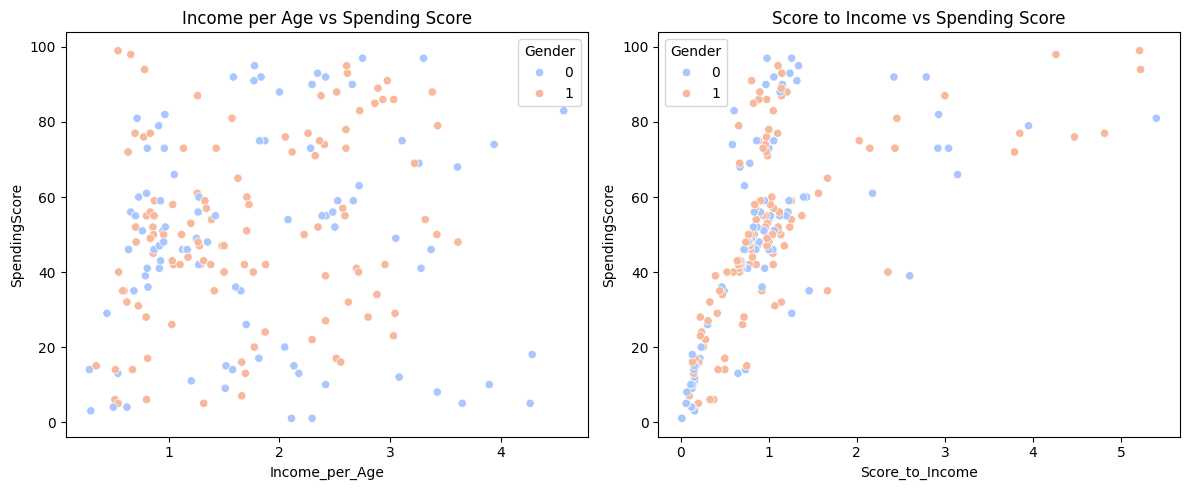

In [239]:
# Visualization of new features
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='Income_per_Age', y='SpendingScore', data=df, hue='Gender', palette='coolwarm')
plt.title('Income per Age vs Spending Score')

plt.subplot(1,2,2)
sns.scatterplot(x='Score_to_Income', y='SpendingScore', data=df, hue='Gender', palette='coolwarm')
plt.title('Score to Income vs Spending Score')
plt.tight_layout()
plt.show()